In [3]:
pip install tensorflow matplotlib wandb huggingface-hub datasets

##### **IMPORT LIBRARIES**

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
import wandb
from wandb.integration.keras import WandbCallback

##### **INITIALIZE WANDB CONFIG**

In [ ]:
wandb.init(project="trash-classification-o", entity="jayaiskandar17-individual")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: jayaiskandar17 (jayaiskandar17-individual). Use `wandb login --relogin` to force relogin


In [ ]:
# LOAD DATASET
dataset = load_dataset("garythung/trashnet")
data_dir = dataset["train"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
import pandas as pd

data_df = pd.DataFrame(data_dir)

print("Class distribution:")
class_counts = data_df["label"].value_counts()
for label, count in class_counts.items():
    print(f"{label}: {count} images")

#### **DATASET PREPROCESSING**

In [ ]:
# PREPROCESS DATA
def preprocess_data(data):
    images = []
    labels = []
    for example in data:
        img = example["image"].resize((224, 224))
        images.append(np.array(img))
        labels.append(example["label"])
    return np.array(images), np.array(labels)

In [ ]:
X, y = preprocess_data(data_dir)
X = preprocess_input(X)  
y = to_categorical(y, num_classes=6)

In [ ]:
# SPLIT DATASET
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
# DATA AUGMENTATION
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train)

#### **LOAD RESNET50 MODEL**

In [ ]:
# LOAD THE RESNET50 MODEL
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze base model layers

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# ADD CUSTOM CLASSIFICATION HEAD
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dense(6, activation="softmax")(x)
model = Model(inputs=base_model.input, outputs=x)

In [ ]:
# COMPILE MODEL
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,165,972 (96.00 MB)

 Trainable params: 526,086 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,052,174 (4.01 MB)

#### **MODEL TRAINING**

In [ ]:
from tensorflow.keras.callbacks import Callback

class WandbCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # LOG METRICS TO WANDB
        wandb.log({
            "epoch": epoch + 1,
            "loss": logs["loss"],
            "accuracy": logs["accuracy"],
            "val_loss": logs["val_loss"],
            "val_accuracy": logs["val_accuracy"],
        })

# TRAIN MODEL
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=[WandbCustomCallback()]  # I ADDED CALLBACK
)

Epoch 1/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 783s 7s/step - accuracy: 0.7297 - loss: 0.7417 - val_accuracy: 0.8773 - val_loss: 0.3417
Epoch 2/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 795s 7s/step - accuracy: 0.8931 - loss: 0.2729 - val_accuracy: 0.8865 - val_loss: 0.3184
Epoch 3/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 786s 7s/step - accuracy: 0.9358 - loss: 0.1794 - val_accuracy: 0.9103 - val_loss: 0.2307
Epoch 4/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 797s 7s/step - accuracy: 0.9526 - loss: 0.1328 - val_accuracy: 0.9156 - val_loss: 0.2520
Epoch 5/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 788s 7s/step - accuracy: 0.9639 - loss: 0.1103 - val_accuracy: 0.9340 - val_loss: 0.2124
Epoch 6/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 783s 7s/step - accuracy: 0.9737 - loss: 0.0926 - val_accuracy: 0.9354 - val_loss: 0.1909
Epoch 7/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 770s 7s/step - accuracy: 0.9808 - loss: 0.0610 - val_accuracy: 0.9380 - val_loss: 0.1993
Epoch 8/10
111/111 ━━━━━━━━━━━━━━━━━━━━ 807s 7s/step - accuracy: 0.9785 - loss: 0.0595 - val_accu

#### **MODEL EVALUATION** 

###### **NOTE: ALTHOUGH THE FULL COMPLETE CHARTS CAN BE ACCESSED THROUGH WANDB DASHBOARD, I GENERATED IT HERE AS WELL FOR MY OWN REFERENCES**

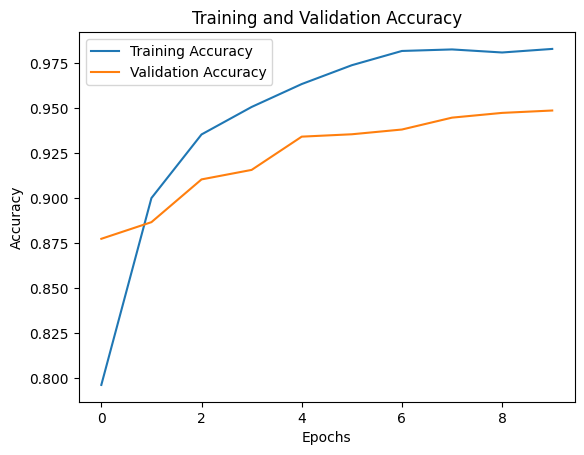

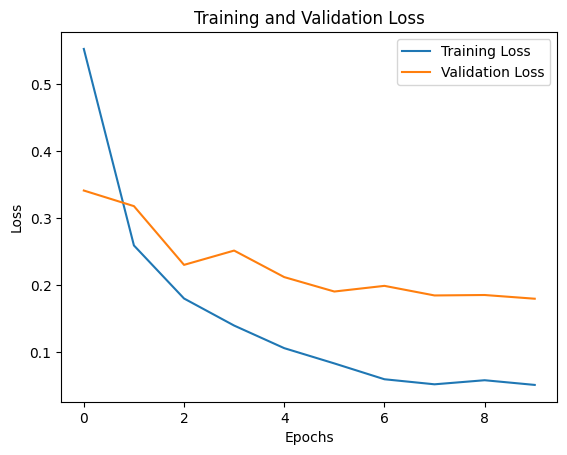

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

##### **SAVE THE MODEL**

In [ ]:
model.save("trash_classification_resnet.h5")

In [22]:
model.save("trash_classification_resnet.keras")

In [23]:
from google.colab import files
files.download("trash_classification_resnet.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
files.download("trash_classification_resnet.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### **IMAGE TESTING**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step


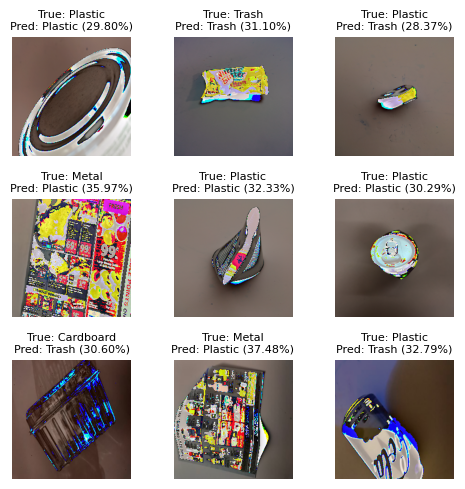

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from random import sample

def preprocess_single_image(image):
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image

def plot_predictions(images, true_labels, model, class_names, num_images=9):

    indices = sample(range(len(images)), num_images)
    selected_images = images[indices]
    true_classes = true_labels[indices]

    plt.figure(figsize=(5, 5))
    for i, img in enumerate(selected_images):

        preprocessed_img = preprocess_single_image(img)
        predictions = model.predict(preprocessed_img)
        predicted_class = np.argmax(predictions, axis=1)[0]
        confidence = np.max(predictions)

        plt.subplot(3, 3, i + 1)
        plt.imshow(img.astype("uint8"))
        plt.title(
            f"True: {class_names[true_classes[i]]}\n"
            f"Pred: {class_names[predicted_class]} ({confidence * 100:.2f}%)",
            fontsize=8  
        )
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(X_test, np.argmax(y_test, axis=1), model, class_names)

#### **HUGGINGFACE SETUP**

In [41]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Y
Token is valid (permission: fineGrained).
The token `jaya-trash` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authentica

In [ ]:
from huggingface_hub import HfApi, upload_file

model_name = "trash-classification-resnet"
repo_id = f"jayaiskandar17/{model_name}"

# CREATE REPO
HfApi().create_repo(repo_id=repo_id, exist_ok=True)

# UPLOAD MODEL FILE
upload_file(
    path_or_fileobj="trash_classification_resnet.keras",
    path_in_repo="trash_classification_resnet.keras",
    repo_id=repo_id,
    commit_message="Upload ResNet50-based model"
)

trash_classification_resnet.keras:   0%|          | 0.00/101M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jayaiskandar17/trash-classification-resnet/commit/c54e859df7da2e52b0ac53068dd6996bf019d6da', commit_message='Upload ResNet50-based model', commit_description='', oid='c54e859df7da2e52b0ac53068dd6996bf019d6da', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jayaiskandar17/trash-classification-resnet', endpoint='https://huggingface.co', repo_type='model', repo_id='jayaiskandar17/trash-classification-resnet'), pr_revision=None, pr_num=None)